### The Project

The Project
The goals / steps of this project are the following:


• Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

• Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

• Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

• Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

• Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

• Estimate a bounding box for vehicles detected.

In [1]:
# Header files and imports

import os
import glob
import math

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from random import shuffle

%matplotlib inline

### Gather and combine all data for vehcile and non - vehicles

In [2]:
base = './dataset/vehicles/'
folders = os.listdir(base)

cars = []
for folder in folders:
    cars.extend(glob.glob(base+folder+'/*'))

base = './dataset/non-vehicles/'
folders = os.listdir(base)

notcars = []
for folder in folders:
    notcars.extend(glob.glob(base+folder+'/*'))
    
shuffle(cars)
shuffle(notcars)
    
print("Number of Vehicle Images found: {}".format(len(cars)))
print("Number of Non-Vehicle Images found: {}".format(len(notcars)))

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [3]:
'''Function to convert the color space of an image'''
def convert_color(img, conv='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    return feature_image

In [4]:
'''Function to display multiple images and plot them'''

def display_img(images, titles, cols=4):
    if(images[0].shape[1]!=images[0].shape[0]):
        rows = math.ceil(len(images)/cols)
        fig = plt.figure(figsize=(17, 4 *  math.ceil(len(images)/cols) ))
    else:
        rows = math.ceil(len(images)/4)
        cols = 4
        fig = plt.figure(figsize=(17, 4 *  math.ceil(len(images)/4) ))

        

    for i, img in enumerate(images):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        plt.title(titles[i])
        if len(img.shape) < 3:
            plt.imshow(img, cmap = "hot")
        else:
            plt.imshow(img)

    plt.tight_layout()

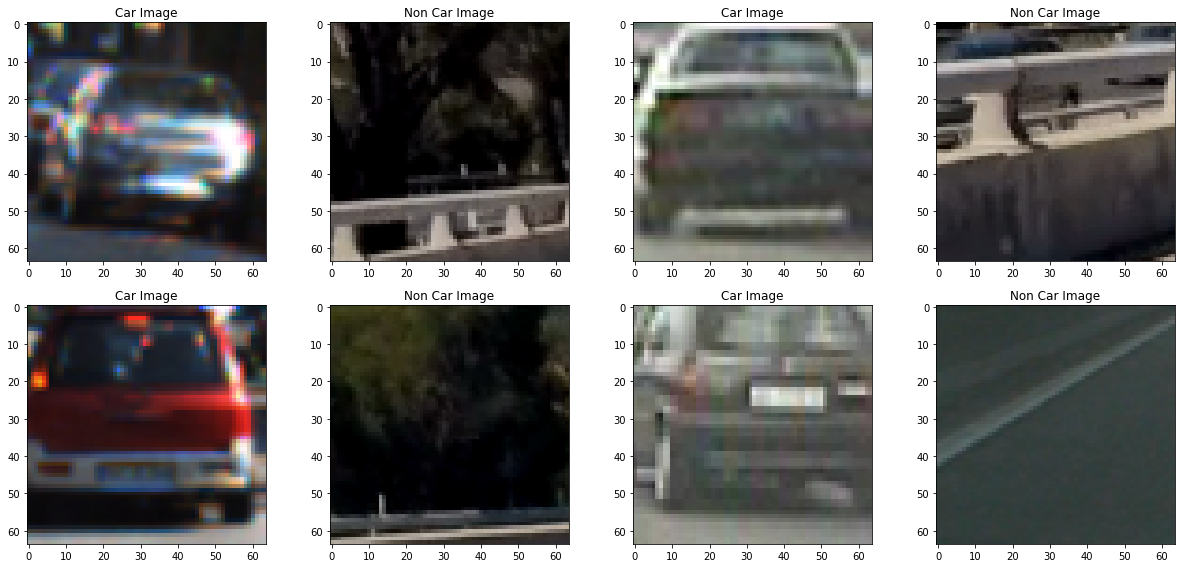

In [5]:
# Display 6 random images

test_images = []
test_titles = []

for i in range(4):
    # Choose random car/notcar indicies
    car_ind = np.random.randint(0,len(cars))
    notcar_ind = np.random.randint(0,len(notcars))

    # Read images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])
    
    test_images.extend([car_image, notcar_image])
    test_titles.extend(["Car Image", "Non Car Image"])
    
display_img(test_images, test_titles)

#Reset
test_images = []
test_titles = []

### Function Definitions

In [6]:
'''Function to return HOG features and visualization'''

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [7]:
'''Function to compute binned color features'''  

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [8]:
'''Function to compute color histogram features'''  

def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

In [9]:
'''Function to extract features from a list of images'''

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                     spatial_size =(32,32),hist_bins =32, use_hog_features = True, \
                     use_spatial_features = True, use_hist_features = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        
        if use_hog_features == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
#             features.append(hog_features)
        else: hog_features =[]
        
        if use_spatial_features == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
#             features.append(spatial_features)
        else : spatial_features =[]
        if use_hist_features == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
        else: hist_festures =[]
#             features.append(hist_features)
        features.append(np.concatenate((hog_features,spatial_features,hist_features)))
    # Return list of feature vectors
    return features

In [10]:
'''Function that takes an image, start and stop positions in both x and y, window size 
(x and y dimensions), and overlap fraction (for both x and y)'''

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
'''Function to draw bounding boxes'''

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(20,255,20), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
'''Function to extract features of a single image only once'''

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    hog_image = []
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))     
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True)

            #else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [13]:
'''Function you will pass an image and the list of windows to be searched'''

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Color histogram visualization

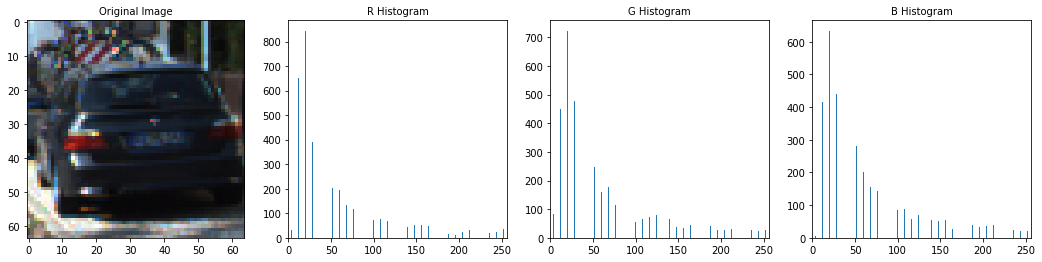

In [14]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
img = cv2.imread(cars[ind])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(18,4));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=10)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=10);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=10);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=10);

### Visualize spatial binning

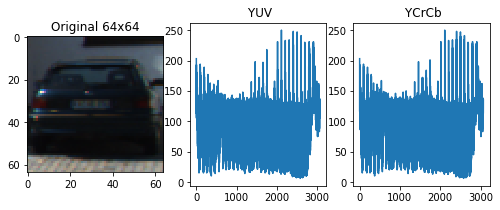

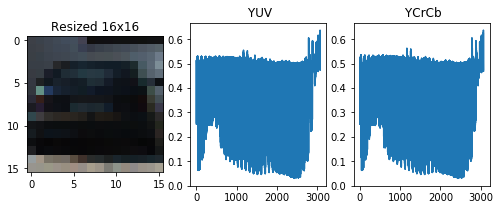

In [15]:

f_vec_YUV = bin_spatial(image, color_space='YUV', size=(32, 32))
f_vec_YCRCB = bin_spatial(image, color_space='YCrCb', size=(32, 32))


# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
small_image = cv2.resize(image, (16, 16))

# Plot features
fig = plt.figure(figsize=(20,3))
plt.subplot(172)
plt.imshow(image)
plt.title('Original 64x64')

plt.subplot(173)
plt.plot(f_vec_YUV)
plt.title(' YUV')
plt.subplot(174)
plt.plot(f_vec_YCRCB)
plt.title(' YCrCb')


f_vec_YUV_16 = bin_spatial(small_image, color_space='YUV', size=(32, 32))
f_vec_YCRCB_16 = bin_spatial(small_image, color_space='YCrCb', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(20,3))
plt.subplot(175)
plt.imshow(small_image)
plt.title('Resized 16x16')

plt.subplot(176)
plt.plot(f_vec_YUV_16)
plt.title(' YUV')
plt.subplot(177)
plt.plot(f_vec_YCRCB_16)
plt.title(' YCrCb')


/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


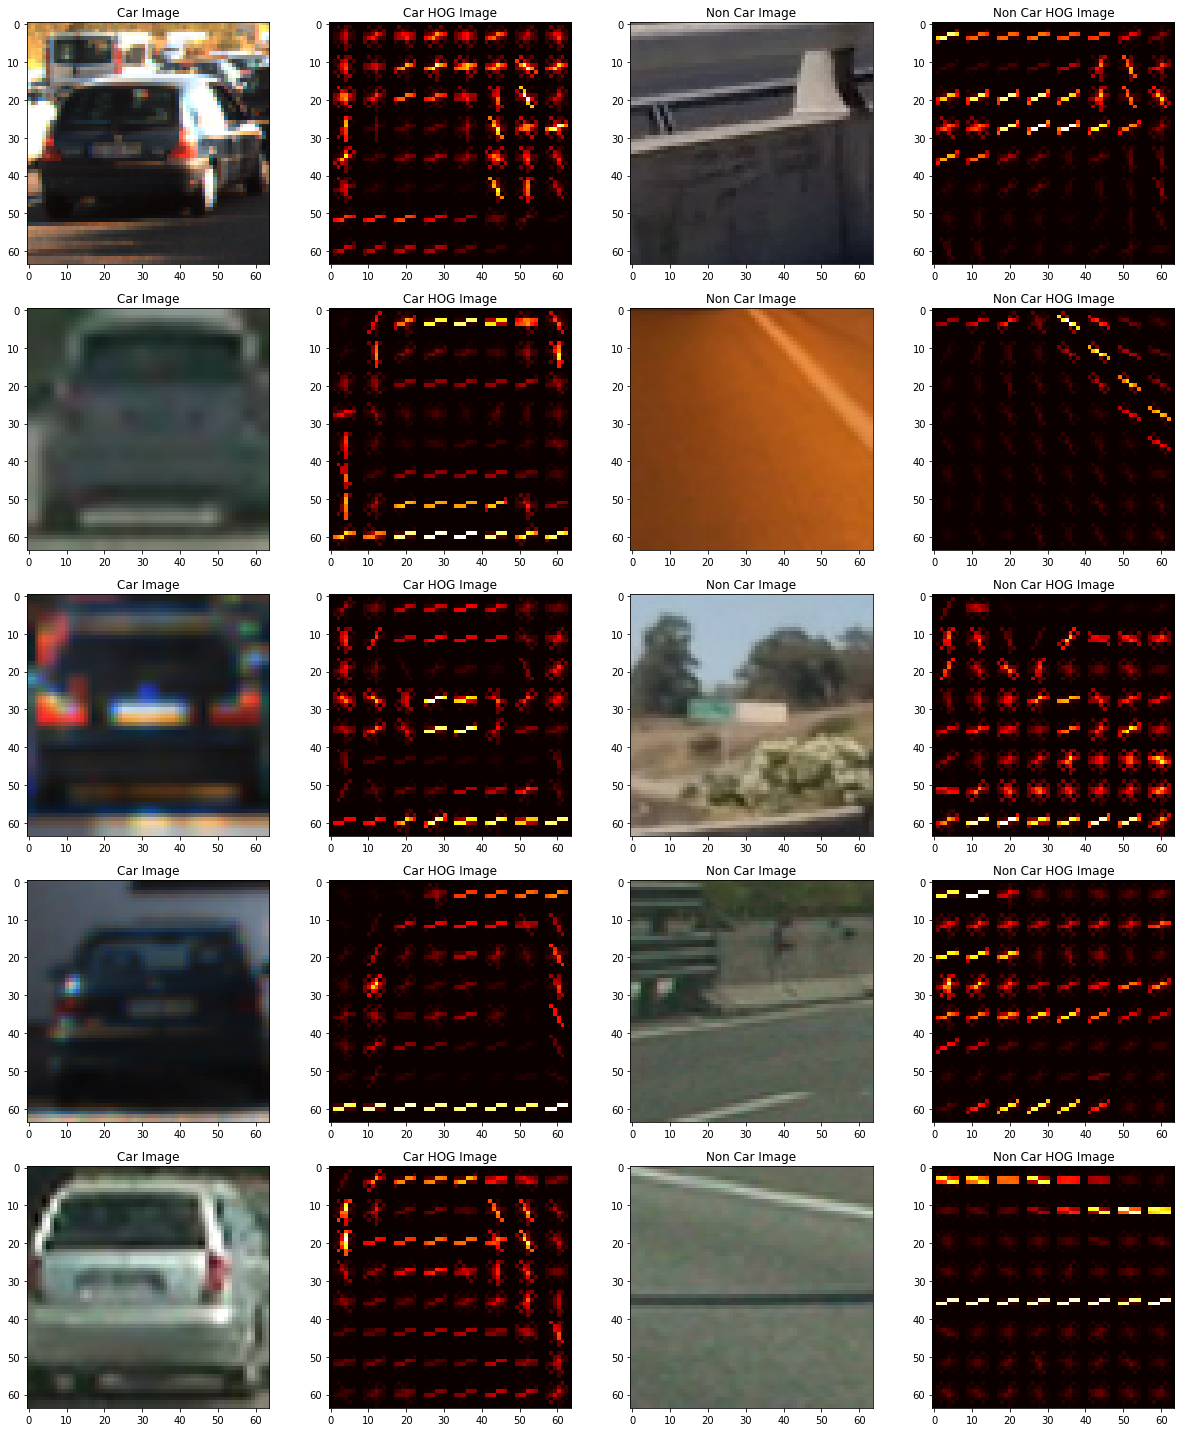

In [16]:
# ----------------------------------  TEST ---------------------------------------------
# Visualize HOG Images

for i in range(5):
    # Choose random car/notcar indicies
    car_ind = np.random.randint(0,len(cars))
    notcar_ind = np.random.randint(0,len(notcars))

    # Read images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Define feature parameters
    color_space = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0 # Can be 0,1,2, "ALL"
    spatial_size = (16,16)
    hist_bins = 16
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                            spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    
    test_images.extend([car_image, car_hog_image, notcar_image, notcar_hog_image])
    test_titles.extend(["Car Image", "Car HOG Image", "Non Car Image", "Non Car HOG Image"])

display_img(test_images,test_titles)
    

#Reset
test_images = []
test_titles = []

### Training the classifier

### Define parameters for features

In [17]:
# Parameters that can be tuned 

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
use_spatial_features = True # Spatial features on or off
use_hist_features = True # Histogram features on or off
use_hog_features = True # HOG features on or off

t1 = time.time()

car_features = extract_features(cars, color_space, orient,pix_per_cell, cell_per_block, hog_channel,\
                                spatial_size,hist_bins,use_hog_features,use_spatial_features,use_hist_features)
                                
non_car_features = extract_features(notcars, color_space, orient,pix_per_cell, cell_per_block, hog_channel,\
                                spatial_size,hist_bins,use_hog_features,use_spatial_features,use_hist_features)

t2 = time.time()

print(round(t2-t1, 2), 'Seconds to extract features...')

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


76.67 Seconds to extract features...


### Normalizing data

In [18]:
# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

In [19]:
print('No. of data points',scaled_X.shape[0])
print('No. of features', scaled_X.shape[1])

No. of data points 17760
No. of features 8460


### Calculating the accuracy of model

In [30]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train,y_test = train_test_split(scaled_X, y,\
                                                    test_size=0.20, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature vector length: 8460
19.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


### Add heat and avoid false positives

In [21]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # zero pixels below threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def add_heat(heatmap, all_bbox):

    for box in all_bbox:
        # Add 1 to pixels inside bounding box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (20, 255,20), 6)                    
                      
    # Return the image
    return img

In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions   
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, \
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    out_window_list =[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # Here division by 255 is done as pipeline image is in jpeg
    # and img color value ranges from 0-255 after reading it using mpimg
    # but the classifier is trained using images whose color value ranges from 0-1
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features,\
                                                          spatial_features,
                                                          hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                out_window = ((xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(20,255,20),6) 
                out_window_list.append(out_window)
    return draw_img,out_window_list

###  Test images results

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


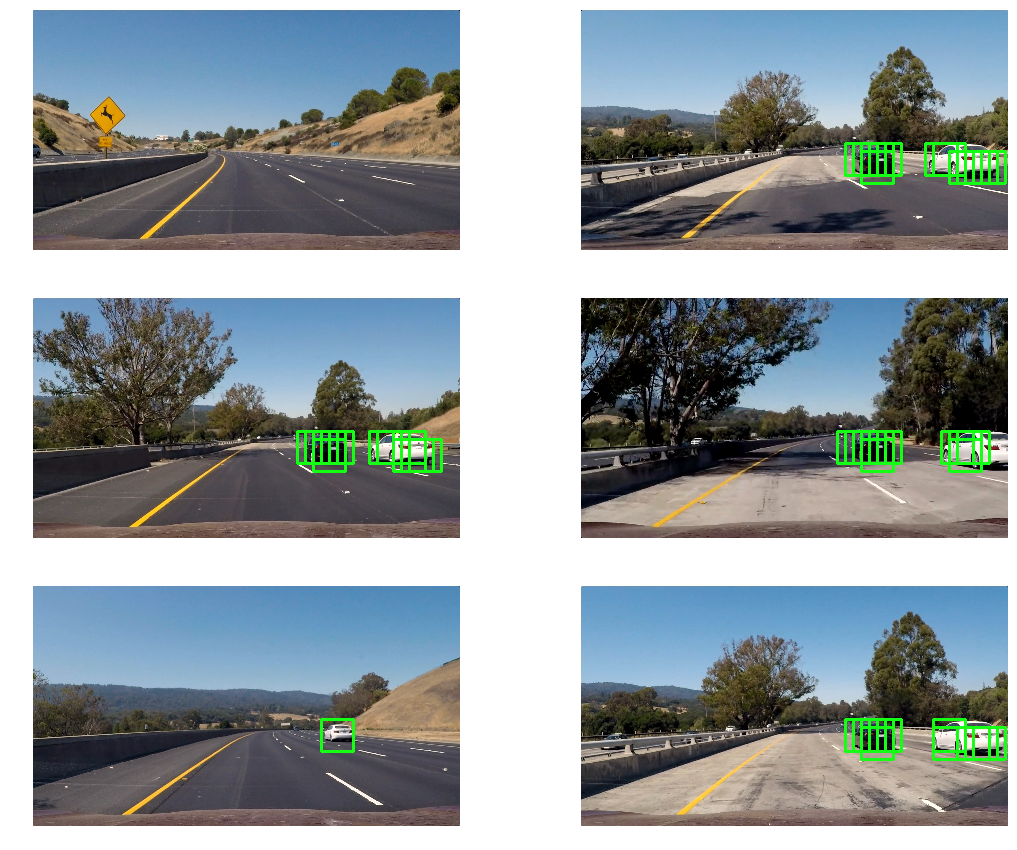

In [23]:

test_images = glob.glob('./test_images/*.jpg')
#print(test_images)
ystart, ystop, scale = 400,656,1.5 # THe cars are present only in the lower half of image 
# To avoud false positives, the window search is only done in lower half of image 

fig, axes = plt.subplots(math.ceil(len(test_images)/2),2, figsize=(18, 15))
axes = axes.ravel()

for idx,test_image in enumerate(test_images):
    img =  mpimg.imread(test_image)
    out_img,out_window_list = find_cars(img, ystart,ystop, scale, svc, X_scaler,
                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axes[idx].imshow(out_img)
    axes[idx].axis('off')

In [24]:
def process_img(img, ystart,ystop, scale, svc, X_scaler,\
             orient, pix_per_cell, cell_per_block, \
             spatial_size, hist_bins,heat_threshold):
    
    out_img,out_window_list = find_cars(img, ystart,\
                                ystop, scale, svc, X_scaler,\
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each detected window in out_window_list
    heat = add_heat(heat, out_window_list)

    #Apply threshold to remove false positves
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap while displaying

    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = np.copy(img)
    return out_img, heatmap, draw_img

### Heat Map

### Threshold for heat map

In [25]:
heat_threshold =1 

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


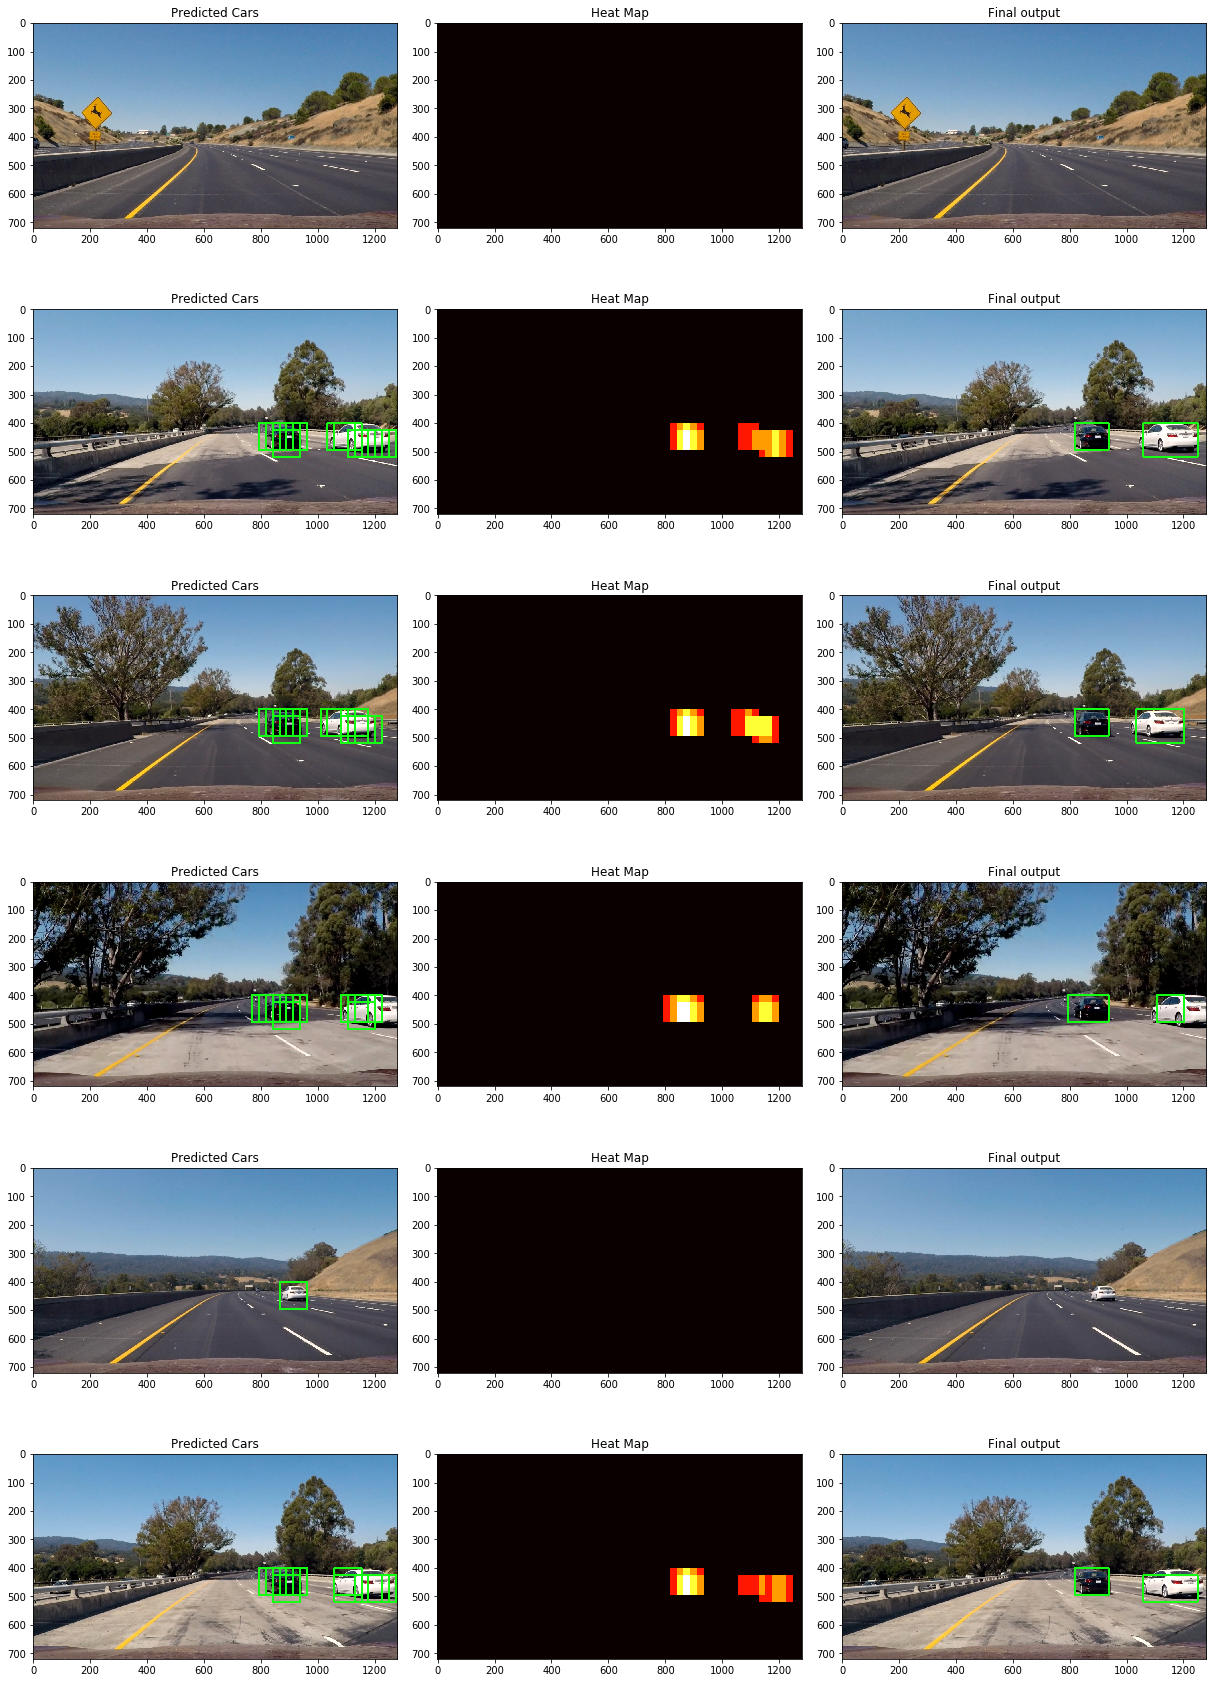

In [26]:
#Reset
test_images2 = []
test_titles2 = []


i = 0
for test_image in test_images:
    img =  mpimg.imread(test_image)
    out_img, heatmap, draw_img = process_img(img, ystart,ystop, scale, svc, X_scaler,\
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, hist_bins,heat_threshold)
    
    test_images2.append(out_img)
    test_titles2.append("Predicted Cars")
    
    test_images2.append(heatmap)
    test_titles2.append("Heat Map")
    
    test_images2.append(draw_img)
    test_titles2.append("Final output")

display_img(test_images2,test_titles2, 3)
    

#Reset
test_images2 = []
test_titles2 = []


In [27]:
def pipeline(img):
    out_img, heatmap, draw_img = process_img(img, ystart,ystop, scale, svc, X_scaler,\
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, hist_bins,heat_threshold)
    return draw_img

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
#clip = VideoFileClip("test_video.mp4")

test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:01<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

